## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.io import wavfile as wav
# from scipy.fftpack import fft
import numpy as np
import os
import librosa
from pathlib import Path
from tqdm import tqdm
import glob
import IPython

## Basic Data sanity check on audio files - Every file has 10s of audio?

In [3]:
# # Meow 
# IPython.display.Audio('./data/google_audioset/google_audioset_Bark_Meow/5TiGP89UErY.wav')
# # Improperly labeled as Meow - Makes this more challenging?
# IPython.display.Audio('./data/google_audioset/google_audioset_Bark_Meow/2TGTLMkOXkg.wav')
# # Bark
# IPython.display.Audio('./data/google_audioset/google_audioset_Bark_Meow/1-kCCA9xxT0.wav')

# Meow 
IPython.display.Audio('./data/google_audioset/google_audioset_Vehicles/google_audioset_Vehicles/__t7BuXSBFc.wav')

In [ ]:
checdf = pd.DataFrame(columns=['yid','size','rate'])
for i in tqdm(glob.glob('./data/google_audioset/google_audioset_Vehicles/google_audioset_Vehicles/*.wav')):
    try:
        X, sr = librosa.load(i)
        checdf = checdf.append({'yid':os.path.basename(i), 'size':X.shape[0],'rate':sr},ignore_index=True)
    except:
        print(f'librosa error for file : {i}')

In [8]:
checdf = checdf.infer_objects(); checdf.describe()
checdf.to_csv('./data/google_audioset/checdf_Vehciles.csv')

,size,rate
count,32651.000000,32651.0
mean,219315.829194,22050.0
std,6773.235153,0.0
min,0.000000,22050.0
25%,220500.000000,22050.0
50%,220500.000000,22050.0
75%,220500.000000,22050.0
max,220500.000000,22050.0


('# Clips with entire 10s of audio', 30346, 0.929404918685492)

('# Clips with <10s of audio', 2305)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6e5d23438>]],
      dtype=object)

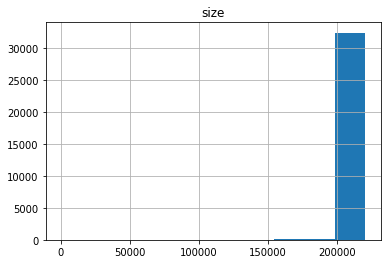

In [9]:
'# Clips with entire 10s of audio', (checdf['size']==220500).sum(), (checdf['size']==220500).sum()/checdf.shape[0]
'# Clips with <10s of audio', (checdf['size']!=220500).sum()
checdf.hist(column='size')

## Audio to Spectrogram

* Thanks to etown for the spectogram code - https://github.com/etown/dl1/blob/master/UrbanSoundClassification.ipynb

In [28]:
wavdata = Path('./data/google_audioset/google_audioset_Vehicles/google_audioset_Vehicles/')
# pngdata = Path('./data/google_audioset/google_audioset_BM_10spng/')
pngdata = Path('./data/google_audioset/google_audioset_Vehicles_allpng/')
if pngdata.exists()==False:
    pngdata.mkdir()

In [14]:
# Code taken directly from https://github.com/etown/dl1/blob/master/UrbanSoundClassification.ipynb with minimal changes 
def spectrogram(wavfile):
    # for i in tqdm(checdf[checdf['size']==220500]['yid'].values):
    print(wavfile)
    fpath = wavdata/wavfile
    try:
        X,sr = librosa.load(fpath)
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        Pxx, freqs, bins, im = plt.specgram(np.array(X), Fs=22050)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
    #     plt.show()
        filename  = pngdata/wavfile.replace('.wav','.png')
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')
    except:
        print(f'error for file : {fpath}')
#     break

In [ ]:
import multiprocessing as mp
mp.cpu_count()
with mp.Pool(7) as pool:
#     pool.map(spectrogram, checdf[checdf['size']==220500]['yid'].values)
    pool.map(spectrogram, checdf['yid'].values)

## Audio to FFT - If Spectogram is not giving accuracy - TBD - Not used can skip

## Audio to (Spectogram, FFT, Amplitude) as 3 channels - If the above two are giving good accuracy - TBD

## Creating the labels.csv file based on the dataset generated above

In [31]:
vehicles = pd.read_csv('./data/google_audioset/Vehicle_clips_metadata', sep=' ')
checdf['YID'] = checdf.yid.apply(lambda x: x.replace('.wav',''))
checdf['label'] = checdf.YID.apply(lambda x : 'Boat' if x in vehicles[vehicles.Boat==1].YTID.values else 'Motorcycle' 
                                   if x in vehicles[vehicles.Motorcycle==1].YTID.values 
                                   else 'Racecar' if x in vehicles[vehicles.Racecar==1].YTID.values 
                                   else 'Helicopter' if x in vehicles[vehicles.Helicopter==1].YTID.values else 'Railroadcar')
checdf.shape, checdf.head()

((32651, 5),                yid    size   rate          YID        label
 0  dOXg-2ocg40.wav  220500  22050  dOXg-2ocg40      Racecar
 1  8vuOH9dLj8I.wav  220500  22050  8vuOH9dLj8I  Railroadcar
 2  fCSspOE27gc.wav  220500  22050  fCSspOE27gc      Racecar
 3  3giD0D2Zo3s.wav  210374  22050  3giD0D2Zo3s  Railroadcar
 4  PXzOrSMkI4w.wav  220500  22050  PXzOrSMkI4w         Boat)

In [34]:
checdf[['YID', 'label']].to_csv('./data/google_audioset/vehicles_all_labels.csv', index=False)

In [35]:
labelpath = Path('./data/google_audioset/vehicles_all_labels.csv')

## CNN classification

### ResNet 34

In [ ]:
data = ImageDataBunch.from_csv(pngdata.parent,
                               pngdata.name,#ds_tfms=get_transforms(),
                              csv_labels = labelpath.name, suffix='.png' ,size=224, bs=128)
data.normalize(imagenet_stats)

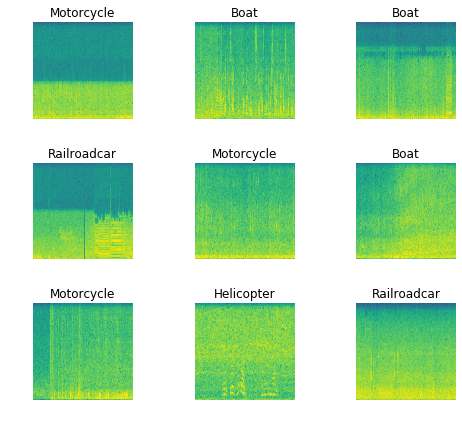

In [102]:
data.show_batch(rows=3, figsize=(7,6))

In [103]:
data.train_dl.one_batch()[0].shape

print(data.classes)
len(data.classes),data.c

torch.Size([128, 3, 217, 223])

['Racecar', 'Railroadcar', 'Boat', 'Helicopter', 'Motorcycle']


(5, 5)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


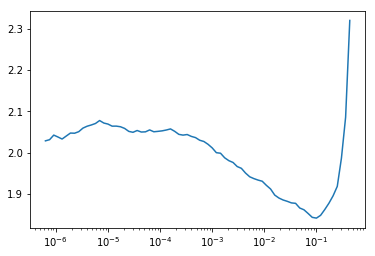

In [104]:
from fastai.vision import models
learn = ConvLearner(data, models.resnet34, metrics=[error_rate, accuracy])
learn.lr_find()
learn.recorder.plot()

In [85]:
learn.fit_one_cycle(10, 1e-2)

Total time: 10:30
epoch  train_loss  valid_loss  error_rate  accuracy
1      1.283993    1.167864    0.464089    0.535911  (01:45)
2      1.106550    1.300851    0.494040    0.505960  (00:57)
3      1.050345    1.185114    0.464242    0.535758  (00:58)
4      1.025248    1.152643    0.441932    0.558068  (00:58)
5      0.978217    1.166860    0.446363    0.553637  (00:58)
6      0.937059    1.079548    0.420079    0.579921  (00:58)
7      0.871605    0.974972    0.378973    0.621027  (00:58)
8      0.807952    0.983214    0.364150    0.635850  (00:58)
9      0.755837    0.897993    0.336186    0.663814  (00:58)
10     0.722381    0.899274    0.335116    0.664884  (00:58)



In [ ]:
learn.recorder.plot_losses()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


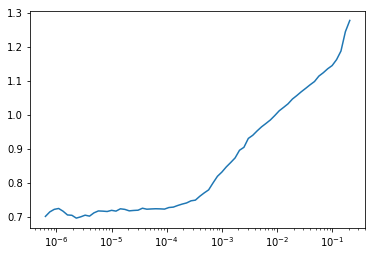

In [86]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [87]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-3))

Total time: 12:38
epoch  train_loss  valid_loss  error_rate  accuracy
1      0.712829    0.905125    0.338172    0.661828  (01:15)
2      0.716264    0.914649    0.337867    0.662133  (01:16)
3      0.687348    0.930830    0.350092    0.649908  (01:15)
4      0.623840    0.997953    0.345507    0.654493  (01:15)
5      0.492341    1.063284    0.352537    0.647463  (01:15)
6      0.362251    1.207052    0.358955    0.641045  (01:15)
7      0.249707    1.359041    0.362317    0.637683  (01:15)
8      0.156834    1.514813    0.365526    0.634474  (01:16)
9      0.111962    1.563949    0.362011    0.637989  (01:15)
10     0.095268    1.574216    0.358191    0.641809  (01:16)



In [ ]:
learn.recorder.plot_losses()

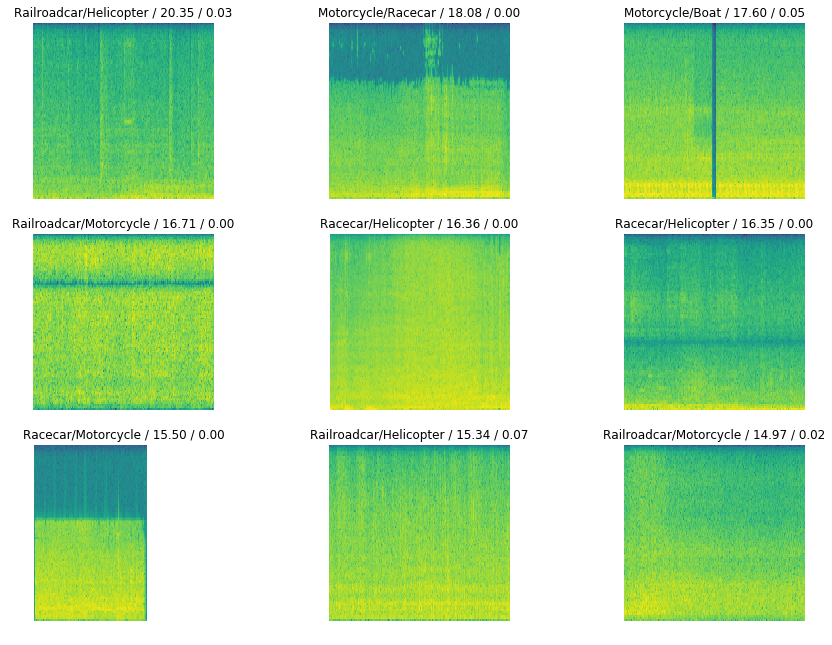

In [88]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

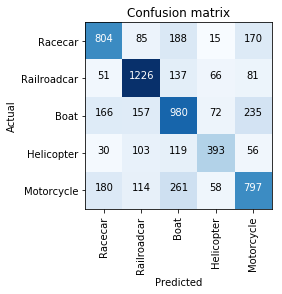

In [89]:
interp.plot_confusion_matrix()

In [90]:
interp.most_confused()

[('Motorcycle', 'Boat', 261),
 ('Boat', 'Motorcycle', 235),
 ('Racecar', 'Boat', 188),
 ('Motorcycle', 'Racecar', 180),
 ('Racecar', 'Motorcycle', 170),
 ('Boat', 'Racecar', 166),
 ('Boat', 'Railroadcar', 157),
 ('Railroadcar', 'Boat', 137),
 ('Helicopter', 'Boat', 119),
 ('Motorcycle', 'Railroadcar', 114),
 ('Helicopter', 'Railroadcar', 103),
 ('Racecar', 'Railroadcar', 85),
 ('Railroadcar', 'Motorcycle', 81),
 ('Boat', 'Helicopter', 72),
 ('Railroadcar', 'Helicopter', 66),
 ('Motorcycle', 'Helicopter', 58),
 ('Helicopter', 'Motorcycle', 56),
 ('Railroadcar', 'Racecar', 51),
 ('Helicopter', 'Racecar', 30),
 ('Racecar', 'Helicopter', 15)]

### ResNet 50

In [91]:
data = ImageDataBunch.from_csv(pngdata.parent,
                               pngdata.name,#ds_tfms=get_transforms(),
                              csv_labels = labelpath.name, suffix='.png' ,size=224, bs=64)
data.normalize(imagenet_stats)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


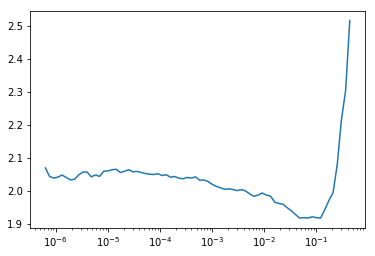

In [92]:
from fastai.vision import models
learn = ConvLearner(data, models.resnet50, metrics=[error_rate, accuracy])
learn.lr_find()
learn.recorder.plot()

In [93]:
learn.fit_one_cycle(10, 1e-2)

Total time: 18:28
epoch  train_loss  valid_loss  error_rate  accuracy
1      1.175835    1.148916    0.436030    0.563970  (01:53)
2      1.091767    1.236285    0.487631    0.512369  (01:51)
3      1.067836    1.239986    0.458643    0.541357  (01:50)
4      1.053422    1.074592    0.415389    0.584611  (01:50)
5      1.009518    1.340933    0.478828    0.521172  (01:50)
6      0.941626    0.918006    0.350888    0.649112  (01:50)
7      0.841028    0.923365    0.351647    0.648353  (01:50)
8      0.770924    0.901192    0.341478    0.658522  (01:50)
9      0.692173    0.883809    0.331158    0.668842  (01:50)
10     0.662574    0.894434    0.330551    0.669449  (01:50)



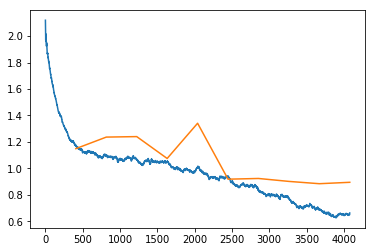

In [94]:
learn.recorder.plot_losses()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


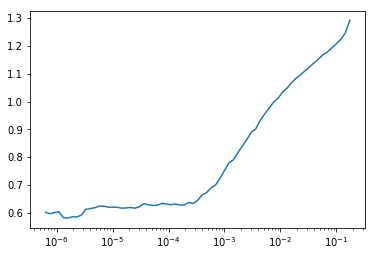

In [95]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [96]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-3))

Total time: 24:36
epoch  train_loss  valid_loss  error_rate  accuracy
1      0.653651    0.914147    0.334497    0.665503  (02:27)
2      0.674484    0.964174    0.348308    0.651692  (02:27)
3      0.625328    1.024400    0.357110    0.642890  (02:27)
4      0.503150    1.049330    0.350433    0.649567  (02:28)
5      0.356759    1.256726    0.366672    0.633328  (02:27)
6      0.227670    1.486601    0.358324    0.641676  (02:27)
7      0.111445    1.696487    0.360753    0.639247  (02:27)
8      0.060150    1.877975    0.358173    0.641827  (02:27)
9      0.027400    1.887919    0.358324    0.641676  (02:27)
10     0.029374    1.931943    0.352102    0.647898  (02:27)



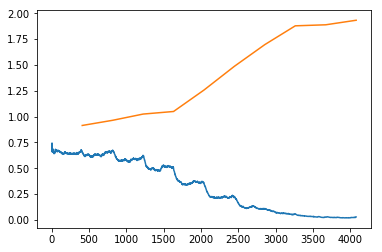

In [97]:
learn.recorder.plot_losses()

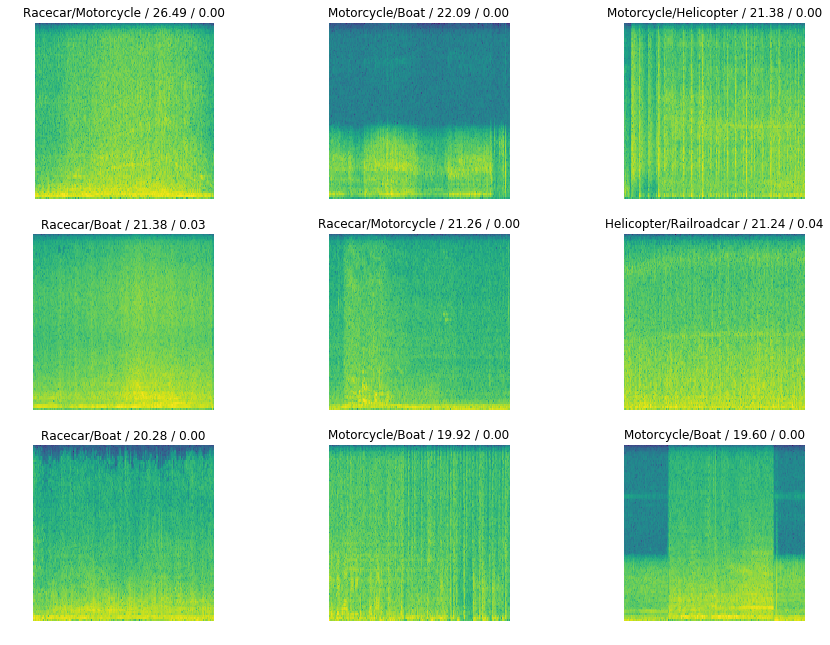

In [98]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

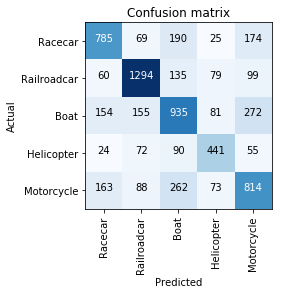

In [99]:
interp.plot_confusion_matrix()

In [100]:
interp.most_confused()

[('Boat', 'Motorcycle', 272),
 ('Motorcycle', 'Boat', 262),
 ('Racecar', 'Boat', 190),
 ('Racecar', 'Motorcycle', 174),
 ('Motorcycle', 'Racecar', 163),
 ('Boat', 'Railroadcar', 155),
 ('Boat', 'Racecar', 154),
 ('Railroadcar', 'Boat', 135),
 ('Railroadcar', 'Motorcycle', 99),
 ('Helicopter', 'Boat', 90),
 ('Motorcycle', 'Railroadcar', 88),
 ('Boat', 'Helicopter', 81),
 ('Railroadcar', 'Helicopter', 79),
 ('Motorcycle', 'Helicopter', 73),
 ('Helicopter', 'Railroadcar', 72),
 ('Racecar', 'Railroadcar', 69),
 ('Railroadcar', 'Racecar', 60),
 ('Helicopter', 'Motorcycle', 55),
 ('Racecar', 'Helicopter', 25),
 ('Helicopter', 'Racecar', 24)]